In [1]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm

from numba import jit



df = load_df()
df = df.fillna(0)

version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"

In [2]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "fix_min_ptu_price_known",  # combine all
    "fix_max_ptu_price_known",  # combine all
    "fix_settlement_price_bestguess_alt",  # combine all
    "settlement_price_bestguess_alt",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    # "igcc_contribution_up_published",
    # "igcc_contribution_down_published",
    "time_since_last_two_sided",
    "time_since_last_two_sided_alt",  # combine all
    "two_sided_daily_count",
    "PTU",
    "minute_in_ptu",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    # "forecast_wind",
    # "forecast_solar",
    # "forecast_demand",
    # "forecast_wind_delta",
    # "forecast_solar_delta",
    # "forecast_demand_delta",
    "fix_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    # "hour",
    "month",
    # "day",
    # "minute",
    # "down_negative",
    "down_price_volume",
    "up_price_volume",
    # "diff_price_volume",
    # "started_down",
    # "max_price_filled_known",
    "last_15min_up_volume",
    "last_15min_down_volume",
    "downward_dispatch_published_peak",
    "downward_dispatch_published_peak_time",
    "downward_dispatch_published_peak_diff",
    # "upward_dispatch_published_peak",
    # "upward_dispatch_published_peak_time",
    # "upward_dispatch_published_peak_diff",
    "igcc_contribution_down_published_peak",
    "igcc_contribution_down_published_peak_time",
    "igcc_contribution_down_published_peak_diff",
    # "igcc_contribution_up_published_peak",
    # "igcc_contribution_up_published_peak_time",
    # "igcc_contribution_up_published_peak_diff",
    # "reconstruction",
    # "last_15min_recon",
    # "recon_diff",
    # "last_15min_recon_true",
    # "recon_diff_true",
    # "last_15min_recon_false",
    # "recon_diff_false",
    # "recon_diff_base",
    # "recon_diff_total",
    # "price_pred",
    # "eneco_pred",
    "min_price_published_1",
    "max_price_published_1",
    "fix_two_sided_ptu_17",
    "settlement_price_realized_17",
    "minute_in_ptu_2"
]
print("Number of used features:", len(features))
splits = get_splits(df, features, target, return_dict_pair=False)

# for key, values in splits.items():
#     for i, value in enumerate(values):
#         if i in [1, 2]:
#             continue
        
#         splits[key][i] = np.log1p(splits[key][i])

# Check if CUDA (GPU) is available and set the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Create PyTorch datasets and dataloaders
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, action, price):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).reshape((len(y), 1)).to(device)
        self.action = torch.tensor(action, dtype=torch.bool).reshape((len(action), 1)).to(device)
        self.price = torch.tensor(price, dtype=torch.float32).reshape((len(price), 1)).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.action[idx], self.price[idx]


mask = ~splits[train_set][1].astype(bool)
t = np.ones(len(mask), dtype=bool)
t[:15 * 2] = False
t[-15 * 2:] = False
mask = mask & t

train_dataset = CustomDataset(
    splits[train_set][0][mask].values.astype(np.float32),
    splits[train_set][1][mask].values.astype(np.float32),
    splits[train_set][3]["naive_strategy_action"].values.astype(np.bool_),
    splits[train_set][3]["settlement_price_realized"].values.astype(np.float32)
)
test_dataset = CustomDataset(
    splits[test_set][0].values.astype(np.float32),
    splits[test_set][1].values.astype(np.float32),
    splits[test_set][3]["naive_strategy_action"].values.astype(np.bool_),
    splits[test_set][3]["settlement_price_realized"].values.astype(np.float32)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(32, 24),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(24, 16),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(16, 12),
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 16),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(16, 24),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(24, 32),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(32, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to validate the model
def validate_model(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, *_ in val_loader:
            reconstructed = model(X_batch)
            loss = criterion(reconstructed, X_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    return val_loss

model = Autoencoder(input_dim=splits[train_set][0].shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.MSELoss()

# Learning rate warm-up function
def lr_lambda(epoch):
    if epoch < 5:  # First 5 epochs are warm-up
        return (5 - epoch) / 5
    return 0.1 ** ((epoch - 5) // 5)  # Decrease LR every 10 epochs after warm-up

# Combine warm-up and step LR schedule
scheduler = LambdaLR(optimizer, lr_lambda)

max_epochs = 1000

# Early stopping parameters
patience = 15  # Number of epochs to wait for improvement
early_stopping_counter = 0
best_val_loss = np.inf
best_model = None

model_version = ""
# model.load_state_dict(load_model(f"autoencoder{model_version}", "neural_networks"))

Number of used features: 41
Using CPU


In [47]:
# Training loop
for epoch in range(max_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch, action_batch, price_batch in train_loader:
        optimizer.zero_grad()
        reconstructed = model(X_batch)
        loss = criterion(reconstructed, X_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Step the scheduler
    scheduler.step()

    train_loss /= len(train_loader)
    val_loss = validate_model(model, val_loader)
    print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")
    
    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        save_model(best_model, f"autoencoder{model_version}", "custom_loss")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Early stopping logic
    if early_stopping_counter >= patience:
        print(f'Early stopping after epoch {epoch+1} with no improvement.')
        break

Epoch 1/1000, Train Loss: 16686825.886989724, Validation Loss: 23027524.513794973
Epoch 2/1000, Train Loss: 10438510.285755066, Validation Loss: 17982266.444876976
Epoch 3/1000, Train Loss: 8868482.454949329, Validation Loss: 17802185.23869713
Epoch 4/1000, Train Loss: 7610169.494745575, Validation Loss: 20239756.265698336
Epoch 5/1000, Train Loss: 6616595.899889381, Validation Loss: 19724798.750307187
Epoch 6/1000, Train Loss: 9119610.664912218, Validation Loss: 23295648.017051492
Epoch 7/1000, Train Loss: 8945097.746940123, Validation Loss: 1875613.2266066512
Epoch 8/1000, Train Loss: 8600015.292713389, Validation Loss: 33812042.17483687
Epoch 9/1000, Train Loss: 8912598.670942763, Validation Loss: 22490154.375119917
Epoch 10/1000, Train Loss: 9132936.768832073, Validation Loss: 58563415.37768124
Epoch 11/1000, Train Loss: 7661825.0547834, Validation Loss: 24103938.986481905
Epoch 12/1000, Train Loss: 5863899.421478019, Validation Loss: 35799866.01314337
Epoch 13/1000, Train Loss: 57

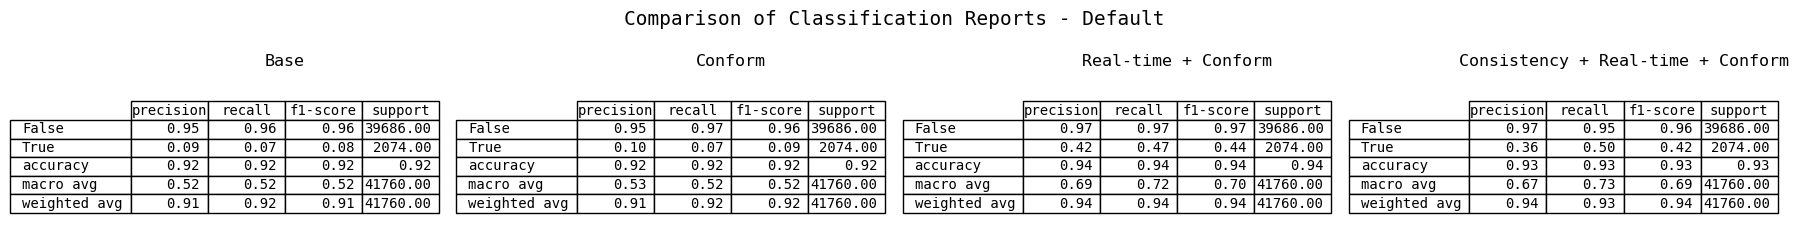

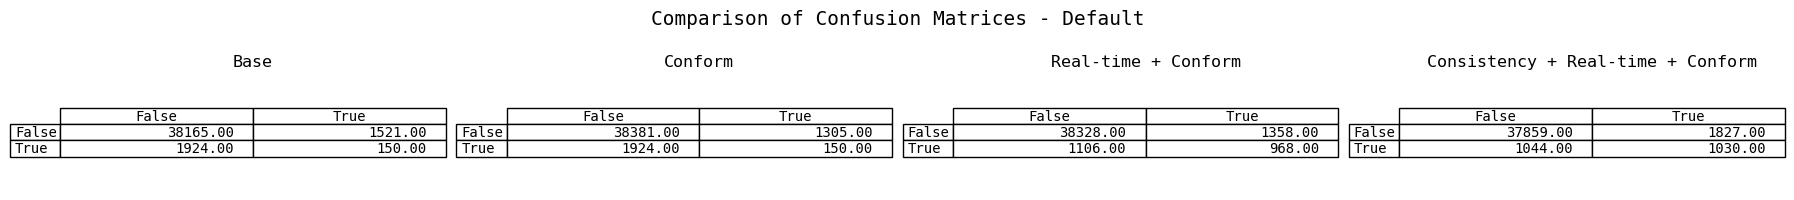

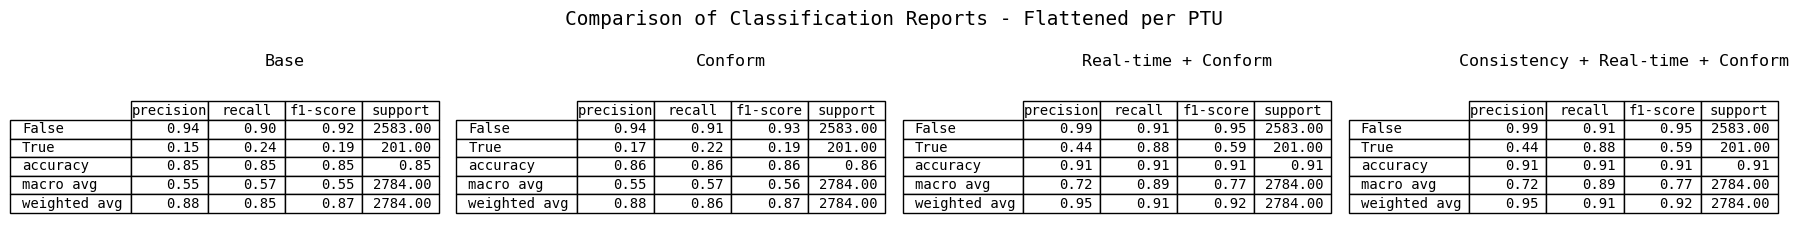

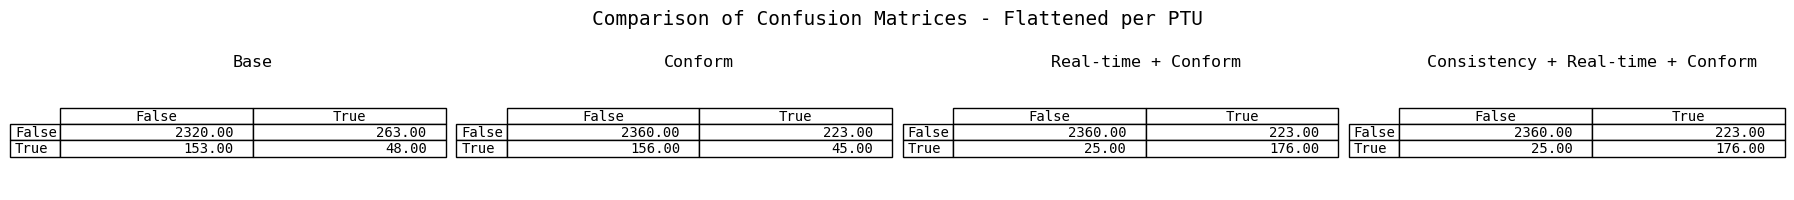

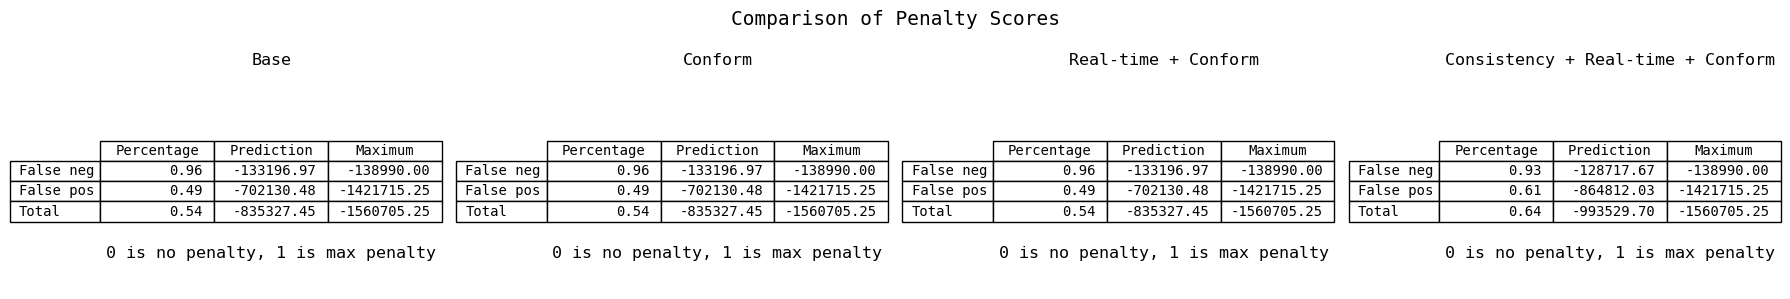

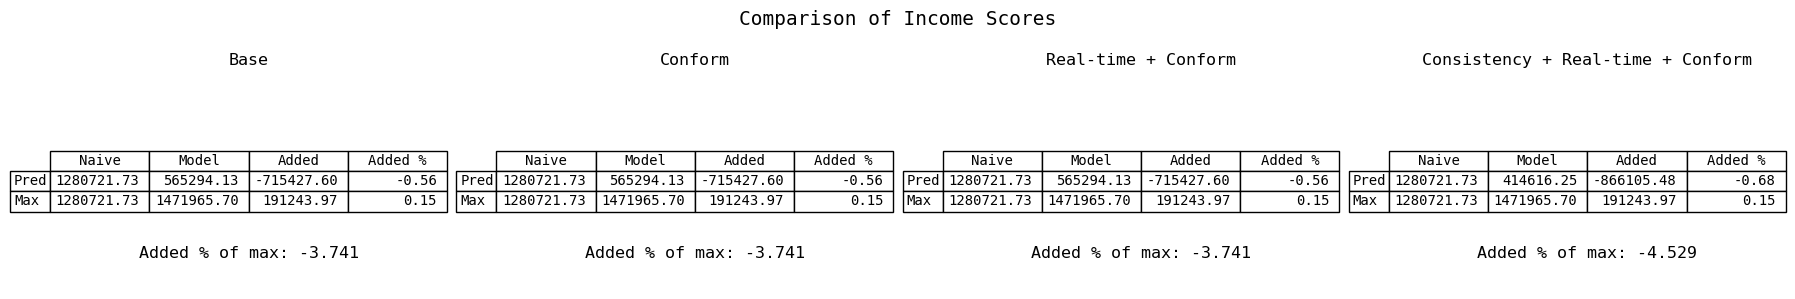

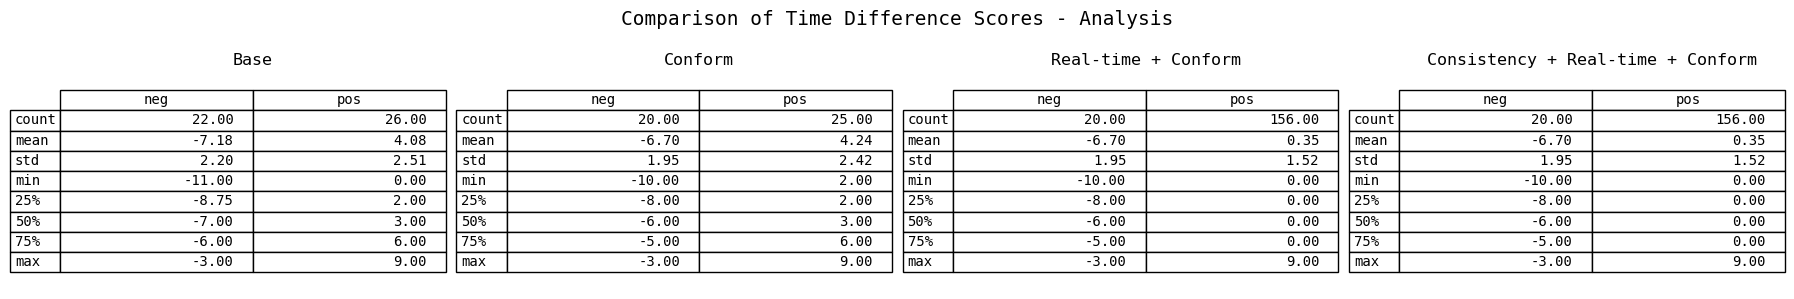

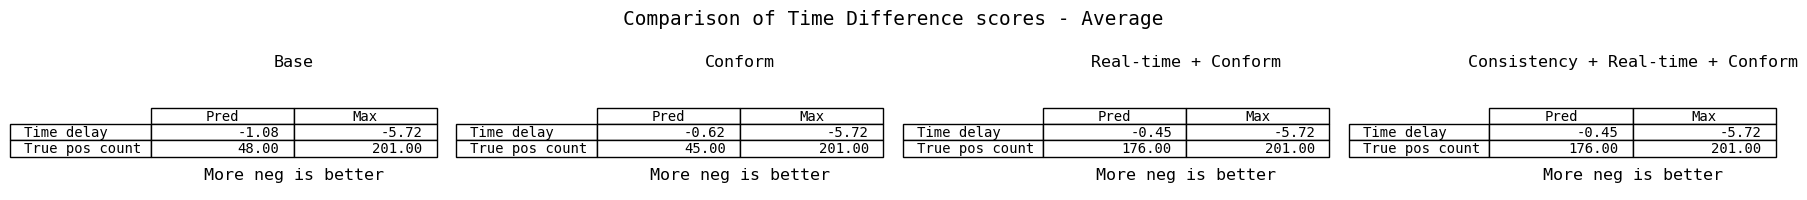

In [48]:
# Load the best model weights
if best_model:
    model.load_state_dict(best_model)


X_test = splits[test_set][0].values.astype(np.float32)
y_test = splits[test_set][1].values.astype(np.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    reconstructed = model(X_test_tensor)
    reconstruction_error = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1).cpu().numpy()

# Determine the threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 96)  # Adjust the percentile based on your needs

# Predict anomalies
y_pred = (reconstruction_error > threshold).astype(bool)

show_metrics_adjusted(splits[test_set][3], pd.Series(y_pred), version=version)


In [11]:
def show_error(splits, split_set: str, show_all=True):
    mask = ~splits[split_set][1]

    X_test = splits[split_set][0][mask].values.astype(np.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        reconstructed = model(X_test_tensor)
        reconstruction_error = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1).cpu().numpy()
        print("True Reconstruct")
        print(pd.Series(reconstruction_error).describe())

    mask = splits[split_set][1]

    X_test = splits[split_set][0][mask].values.astype(np.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        reconstructed = model(X_test_tensor)
        reconstruction_error = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1).cpu().numpy()
        print("False Reconstruct")
        print(pd.Series(reconstruction_error).describe())
    
    if show_all:
        X_test = splits[split_set][0].values.astype(np.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

        with torch.no_grad():
            reconstructed = model(X_test_tensor)
            reconstruction_error = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1).cpu().numpy()
            print("All Reconstruct")
            print(pd.Series(reconstruction_error).describe())

In [12]:
model.load_state_dict(load_model(f"autoencoder{model_version}", "neural_networks"))
print("TRAIN - MODEL")
show_error(splits, train_set)

TRAIN - MODEL
True Reconstruct
count    1.121400e+05
mean     1.543552e+07
std      3.688715e+08
min      8.393430e+02
25%      2.175776e+05
50%      5.376422e+05
75%      1.287820e+06
max      4.080888e+10
dtype: float64
False Reconstruct
count    1.170000e+04
mean     2.656627e+07
std      4.323836e+08
min      4.761248e+02
25%      1.738973e+05
50%      4.143383e+05
75%      9.869323e+05
max      2.027572e+10
dtype: float64
All Reconstruct
count    1.238400e+05
mean     1.579945e+07
std      4.108609e+08
min      4.867207e+02
25%      2.124724e+05
50%      5.282598e+05
75%      1.260585e+06
max      7.859939e+10
dtype: float64


In [13]:
print("VALID - MODEL")
show_error(splits, test_set)

VALID - MODEL
True Reconstruct
count    3.786000e+04
mean     8.369102e+07
std      1.197144e+09
min      9.467648e+02
25%      1.909528e+05
50%      4.610203e+05
75%      1.128041e+06
max      6.553494e+10
dtype: float64
False Reconstruct
count    3.900000e+03
mean     1.792352e+07
std      2.841663e+08
min      2.331295e+03
25%      1.488486e+05
50%      3.497946e+05
75%      9.136906e+05
max      1.177701e+10
dtype: float64
All Reconstruct
count    4.176000e+04
mean     7.547631e+07
std      1.071083e+09
min      1.102209e+03
25%      1.834771e+05
50%      4.525427e+05
75%      1.094212e+06
max      5.918891e+10
dtype: float64


In [14]:
print("TRAIN")
show_error(splits, "train")

TRAIN
True Reconstruct
count    1.121400e+05
mean     1.417619e+07
std      3.447616e+08
min      5.886589e+02
25%      2.174464e+05
50%      5.388160e+05
75%      1.287187e+06
max      4.386096e+10
dtype: float64
False Reconstruct
count    1.170000e+04
mean     3.080693e+07
std      5.577465e+08
min      6.066516e+02
25%      1.732256e+05
50%      4.166983e+05
75%      9.799166e+05
max      2.944257e+10
dtype: float64
All Reconstruct
count    1.238400e+05
mean     1.443968e+07
std      2.995388e+08
min      5.128546e+02
25%      2.120244e+05
50%      5.259548e+05
75%      1.260719e+06
max      2.222319e+10
dtype: float64


In [15]:
print("VALID")
show_error(splits, "valid")

VALID
True Reconstruct
count    3.786000e+04
mean     7.604354e+07
std      1.039757e+09
min      7.237864e+02
25%      1.892081e+05
50%      4.597281e+05
75%      1.132265e+06
max      5.145480e+10
dtype: float64
False Reconstruct
count    3.900000e+03
mean     4.606407e+07
std      1.486264e+09
min      1.663911e+03
25%      1.518371e+05
50%      3.554940e+05
75%      9.258064e+05
max      8.909881e+10
dtype: float64
All Reconstruct
count    4.176000e+04
mean     7.533299e+07
std      1.109349e+09
min      1.242081e+03
25%      1.856613e+05
50%      4.530912e+05
75%      1.098240e+06
max      6.497939e+10
dtype: float64


In [16]:
print("TEST")
show_error(splits, "test")

TEST
True Reconstruct
count    5.131800e+04
mean     1.419246e+07
std      2.503822e+08
min      7.949560e+02
25%      3.544750e+05
50%      7.695516e+05
75%      1.723405e+06
max      2.611022e+10
dtype: float64
False Reconstruct
count    3.328000e+03
mean     7.619880e+06
std      1.391665e+08
min      4.159801e+03
25%      2.249606e+05
50%      4.897778e+05
75%      9.397549e+05
max      6.391034e+09
dtype: float64
All Reconstruct
count    5.464600e+04
mean     1.238091e+07
std      1.729935e+08
min      1.058711e+03
25%      3.463191e+05
50%      7.488189e+05
75%      1.674636e+06
max      1.734380e+10
dtype: float64


In [17]:
print("FULL")
show_error(splits, "full", show_all=False)

X_test = splits["full"][0].values.astype(np.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    reconstructed = model(X_test_tensor)
    reconstruction_error = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1).cpu().numpy()
print("All Reconstruct")
reconstruct = pd.Series(reconstruction_error)
print(reconstruct.describe())

from tweedejaars_project import config
save_df(reconstruct, config.PROCESSED_DATA_DIR / f"reconstruction_error{model_version}.pkl")

with torch.no_grad():
    encoded = model.encoder(X_test_tensor)
    encoded_df = pd.DataFrame(encoded.cpu().numpy())
save_df(encoded_df, config.PROCESSED_DATA_DIR / f"encoded{model_version}.pkl")

FULL
True Reconstruct
count    2.013180e+05
mean     2.600352e+07
std      6.509424e+08
min      5.735301e+02
25%      2.371271e+05
50%      5.796587e+05
75%      1.367944e+06
max      8.436732e+10
dtype: float64
False Reconstruct
count    1.892800e+04
mean     1.945548e+07
std      3.844379e+08
min      5.621561e+02
25%      1.699641e+05
50%      4.209033e+05
75%      9.534822e+05
max      2.779973e+10
dtype: float64
All Reconstruct
count    2.202460e+05
mean     2.365591e+07
std      5.043671e+08
min      7.096089e+02
25%      2.297608e+05
50%      5.647124e+05
75%      1.332134e+06
max      5.825103e+10
dtype: float64


In [18]:
# Determine the threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 96)  # Adjust the percentile based on your needs

# Predict anomalies
y_pred = (reconstruction_error > threshold).astype(bool)

show_metrics_adjusted(splits[test_set][3], pd.Series(y_pred), version=version)

ValueError: Found input variables with inconsistent numbers of samples: [41760, 220246]

In [ ]:
p_tr, _ = test(best[0], splits["train"][0])
show_metrics_adjusted(splits["train"][3], p_tr, version=version)

p_va, _ = test(best[0], splits["valid"][0])
show_metrics_adjusted(splits["valid"][3], p_va, version=version)

p_te, _ = test(best[0], splits["test"][0])
show_metrics_adjusted(splits["test"][3], p_te, version=version)

NameError: name 'test' is not defined

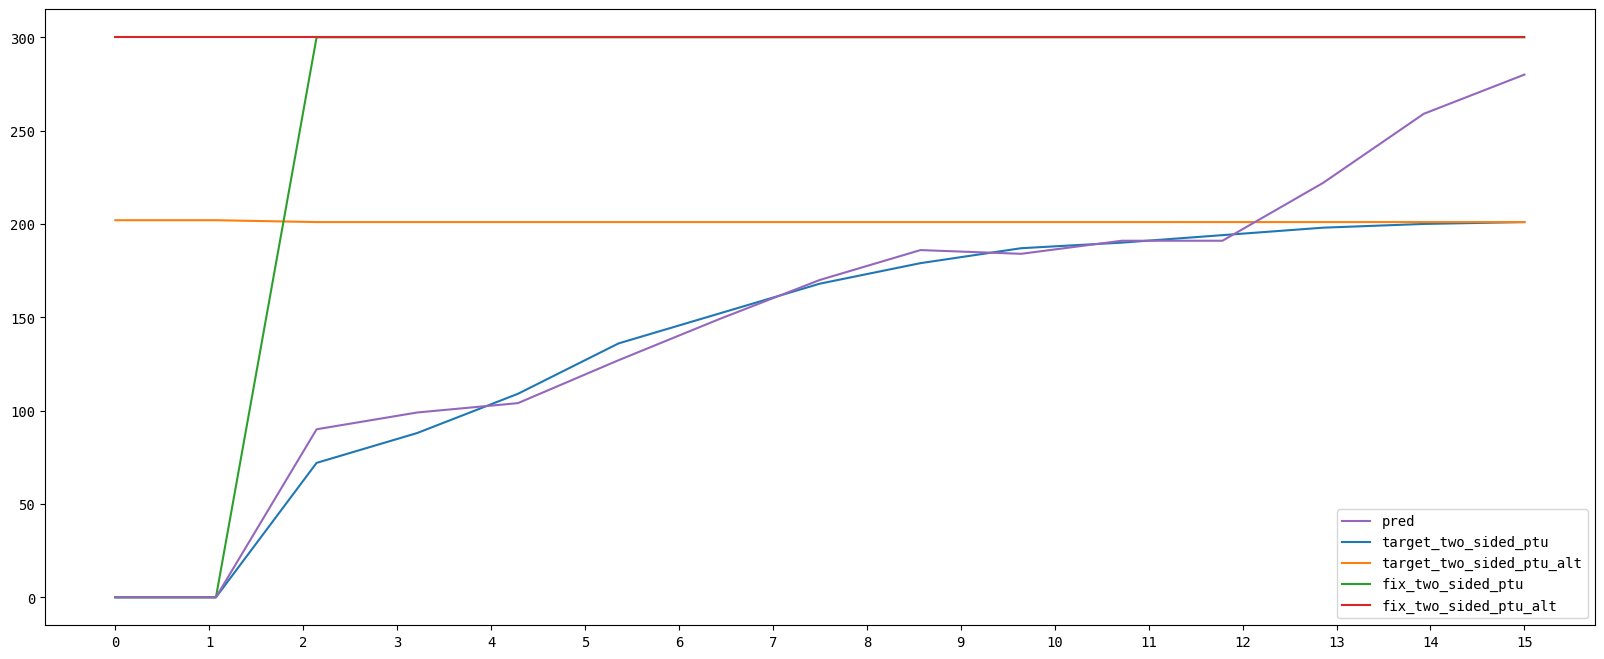

In [ ]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    # "target_two_sided_ptu_realtime",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    # "fix_two_sided_ptu_realtime",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = p1
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()